In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)
    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0
    return ff[['mkt_excess', 'rf']].dropna()

csv_path = "F-F_Research_Data_Factors.csv"
ff = load_ff_monthly_from_ken_french(csv_path)
ff

,mkt_excess,rf
date,,
1926-07-01,0.0289,0.0022
1926-08-01,0.0264,0.0025
1926-09-01,0.0038,0.0023
1926-10-01,-0.0327,0.0032
1926-11-01,0.0254,0.0031
...,...,...
2025-06-01,0.0486,0.0034
2025-07-01,0.0198,0.0034
2025-08-01,0.0184,0.0038


In [4]:
def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt

In [10]:
def compute_S_and_x_for_method6(mkt_total: pd.Series):
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")
    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type

def build_method6_raw_weights(
    mkt_total,
    min_obs=120,
):
    idx        = mkt_total.index
    # S_t, x_t を計算
    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj    = mkt_total - mkt_mean
    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = mask.sum()
        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x[mask].values
        yi = y_adj[mask].values
        denom = (xi ** 2).sum()
        beta[t] = (xi * yi).sum() / denom if denom > 0 else np.nan

    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = beta[t] * x[t]

    return x, beta, w_raw

In [11]:
mkt_excess = ff["mkt_excess"].copy()
rf         = ff["rf"].copy()
mkt_total  = mkt_excess + rf
idx        = mkt_total.index

In [12]:
x, beta, w = build_method6_raw_weights(mkt_total)

In [13]:
def vol_target_from_weights(
    mkt_excess: pd.Series,
    w_raw: pd.Series,
    target_vol: float = 0.05,
) -> pd.DataFrame:
    """
    任意の raw weight w_raw に対して、
    - strat_excess_raw = w_raw * mkt_excess
    - その実現ボラからスケール係数を計算
    - 目標ボラ target_vol に合わせる

    戻り値:
      DataFrame:
        ['mkt_excess','rf',
         'w_raw','w_scaled',
         'strat_excess_raw','strat_excess','strat_total']
    """
    data = pd.concat(
        [mkt_excess.rename("mkt_excess"),
         w_raw.rename("w_raw")],
        axis=1
    ).dropna()

    strat_excess_raw = data["w_raw"] * data["mkt_excess"]

    # 実現ボラ
    realized_vol = strat_excess_raw.std(ddof=1)
    if realized_vol is None or realized_vol == 0 or np.isnan(realized_vol):
        scale = 1.0
    else:
        scale = target_vol / realized_vol

    w_scaled     = data["w_raw"] * scale
    strat_excess = strat_excess_raw * scale
    strat_total  = strat_excess

    out = pd.DataFrame({
        "mkt_excess": data["mkt_excess"],
        "w_raw": data["w_raw"],
        "w_scaled": w_scaled,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess": strat_excess,
        "strat_total": strat_total,
    })
    out.attrs["scale"] = scale
    out.attrs["target_vol"] = target_vol
    return out


In [14]:
target_vol = 0.05
strat_m6 = vol_target_from_weights(ff["mkt_excess"], w, target_vol=target_vol)

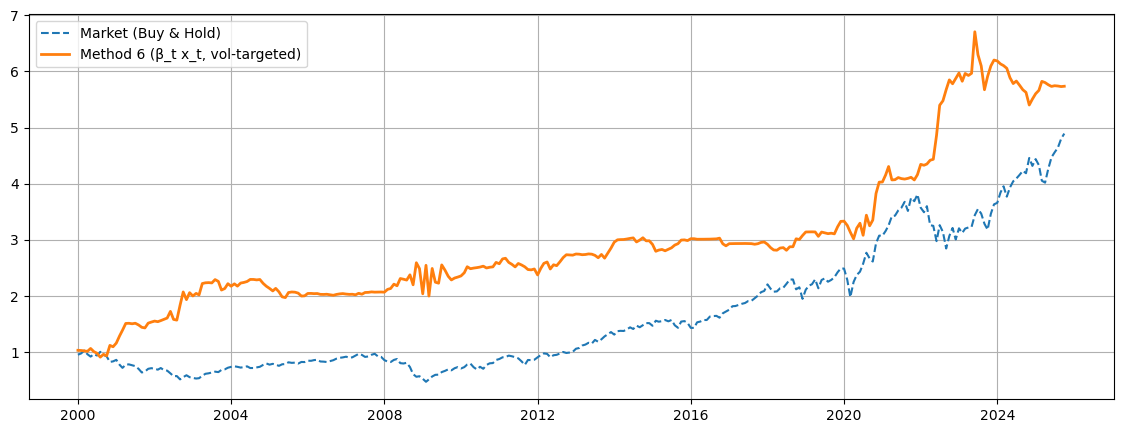

In [38]:
plt.figure(figsize=(14, 5))
plt.plot(
    (1 + strat_m6["mkt_excess"].loc["2000-01-01":]).cumprod(),    label="Market (Buy & Hold)", linestyle="--")
plt.plot(
    (1 + strat_m6["strat_excess"].loc["2000-01-01":]).cumprod(), label="Method 6 (β_t x_t, vol-targeted)", linewidth=2)
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import yfinance as yf

# ダウ平均 (^DJI) を取得
ticker = "^DJI"
df = yf.download(ticker, start="1990-01-01", end="2025-12-31")

[*********************100%***********************]  1 of 1 completed


In [32]:
dji = df["Close"].resample("M").last().pct_change().dropna()[ticker]

In [33]:
x_dji, beta_dji, w_dj = build_method6_raw_weights(dji)

In [34]:
strat_dji = vol_target_from_weights(dji, w_dj, target_vol=target_vol)

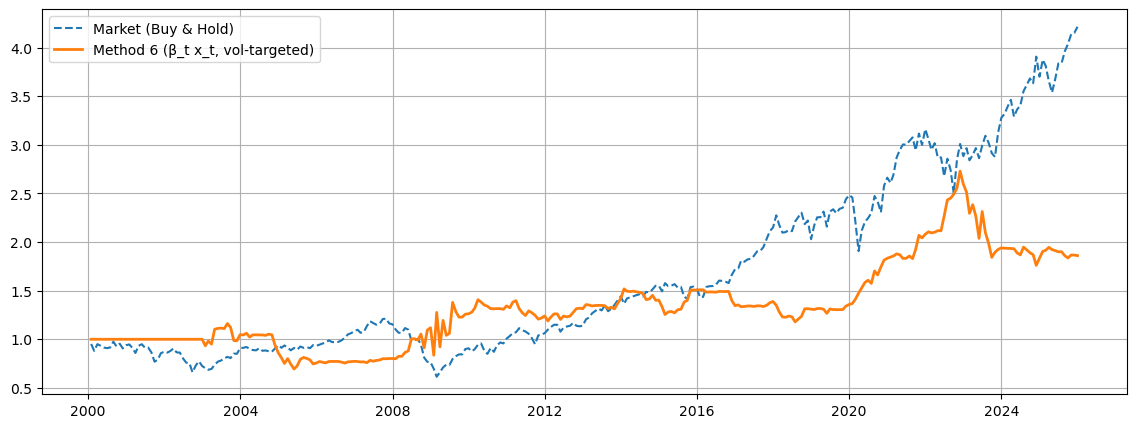

In [36]:
plt.figure(figsize=(14, 5))
plt.plot(
    (1 + strat_dji["mkt_excess"].loc["2000-01-01":]).cumprod(),    label="Market (Buy & Hold)", linestyle="--")
plt.plot(
    (1 + strat_dji["strat_excess"].loc["2000-01-01":]).cumprod(), label="Method 6 (β_t x_t, vol-targeted)", linewidth=2)
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm


# ============================================================
# 1) SPY 日次（堅牢に Close を Series 化）
# ============================================================

def load_spy_daily(start="1993-01-01", end=None):
    data = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)

    if data is None or len(data) == 0:
        raise ValueError("yfinance returned empty data. Try changing date range or retry later.")

    # MultiIndex columns の場合にも対応
    if isinstance(data.columns, pd.MultiIndex):
        # 例: ('Close','SPY')
        if ("Close", "SPY") in data.columns:
            px = data[("Close", "SPY")]
        else:
            close_cols = [c for c in data.columns if c[0] == "Close"]
            if len(close_cols) == 0:
                raise ValueError(f"Close column not found. columns={data.columns}")
            px = data[close_cols[0]]
    else:
        if "Close" not in data.columns:
            raise ValueError(f"Close column not found. columns={data.columns}")
        px = data["Close"]

    # Series に強制
    if isinstance(px, pd.DataFrame):
        if px.shape[1] != 1:
            raise ValueError(f"Unexpected Close DataFrame shape: {px.shape}")
        px = px.iloc[:, 0]

    px = px.dropna()
    if len(px) < 50:
        raise ValueError(f"Too few observations: {len(px)}")

    px.name = "px"
    df = px.to_frame()
    df["ret"] = df["px"].pct_change()
    df = df.dropna()
    return df


# ============================================================
# 2) 第3金曜（暦）→ 取引日にスナップ
# ============================================================

def third_friday_dates(trading_index: pd.DatetimeIndex):
    start = trading_index.min().to_period("M").start_time
    end = trading_index.max().to_period("M").end_time

    # 暦上の第3金曜
    cal = pd.date_range(start=start, end=end, freq="WOM-3FRI")

    snapped = []
    for d in cal:
        dd = d
        # 休場の場合は直前営業日に寄せる（簡易）
        while dd not in trading_index:
            dd = dd - pd.Timedelta(days=1)
            if dd < trading_index.min():
                break
        if dd in trading_index:
            snapped.append(dd)

    return pd.DatetimeIndex(sorted(set(snapped)))


# ============================================================
# 3) カレンダー効果特徴量（TOM / 曜日 / 月 / 第3金曜 / 休日前後など）
# ============================================================

def build_calendar_features(df: pd.DataFrame, tom_pre=1, tom_post=3):
    """
    TOM: 月末最終営業日を基準に、[-tom_pre, +tom_post] 営業日を 1 にする
    （例: tom_pre=1,tom_post=3 -> [-1,+3]）
    """
    out = df.copy()
    idx = out.index

    # 曜日・月
    out["dow"] = idx.dayofweek.astype(int)  # 0..4
    out["month"] = idx.month.astype(int)    # 1..12

    # 取引日ベースの月末（最終営業日）
    month_ends = out["px"].resample("M").last().index
    out["is_month_end"] = idx.isin(month_ends).astype(int)

    # 月初（最初の取引日）
    month_first_trading = out["px"].groupby([idx.year, idx.month]).head(1).index
    out["is_month_start"] = idx.isin(month_first_trading).astype(int)

    # 四半期末月（3,6,9,12）
    out["is_q_end_month"] = idx.month.isin([3, 6, 9, 12]).astype(int)

    # 第3金曜（オプション満期近似）とトリプルウィッチング（四半期末第3金曜）
    tf = third_friday_dates(idx)
    out["is_third_friday"] = idx.isin(tf).astype(int)
    out["is_triple_witching"] = ((out["is_third_friday"] == 1) & (out["is_q_end_month"] == 1)).astype(int)

    # TOM 窓ダミー（営業日シフトで作る）
    tom = pd.Series(0, index=idx, dtype=int)
    for me in month_ends:
        if me not in idx:
            continue
        loc = idx.get_loc(me)
        a = max(loc - tom_pre, 0)
        b = min(loc + tom_post, len(idx) - 1)
        tom.iloc[a:b+1] = 1
    out["is_TOM"] = tom.astype(int)

    # 祝日前後（簡易）：次取引日までのカレンダー日差 >=3 を「休日前っぽい」とする（週末含む）
    next_day = idx.to_series().shift(-1)
    gap = (next_day - idx.to_series()).dt.days
    out["is_pre_holiday_like"] = (gap >= 3).fillna(0).astype(int)

    prev_day = idx.to_series().shift(1)
    gap_prev = (idx.to_series() - prev_day).dt.days
    out["is_post_holiday_like"] = (gap_prev >= 3).fillna(0).astype(int)

    return out


# ============================================================
# 4) デザイン行列（object dtype を潰して statsmodels に渡す）
# ============================================================

def make_design_matrix(cal: pd.DataFrame,
                       include_dow=True,
                       include_month=True,
                       include_tom=True,
                       include_third_friday=True,
                       include_triple_witching=True,
                       include_q_end=True,
                       include_holiday_like=True):

    X_parts = []

    if include_tom:
        X_parts.append(cal[["is_TOM"]])

    if include_dow:
        dow = pd.get_dummies(cal["dow"], prefix="dow", drop_first=True)
        X_parts.append(dow)

    if include_month:
        mon = pd.get_dummies(cal["month"], prefix="mon", drop_first=True)
        X_parts.append(mon)

    if include_third_friday:
        X_parts.append(cal[["is_third_friday"]])

    if include_triple_witching:
        X_parts.append(cal[["is_triple_witching"]])

    if include_q_end:
        X_parts.append(cal[["is_month_end", "is_month_start"]])

    if include_holiday_like:
        X_parts.append(cal[["is_pre_holiday_like", "is_post_holiday_like"]])

    X = pd.concat(X_parts, axis=1)
    X = X.loc[cal.index]

    # ★重要：数値へ強制変換（object 混入を根絶）
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)

    return X


# ============================================================
# 5) OLS + HAC(Newey-West)
# ============================================================

def hac_ols(y: pd.Series, X: pd.DataFrame, lags=5):
    Xc = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, Xc).fit(cov_type="HAC", cov_kwds={"maxlags": lags})
    return model


# ============================================================
# 6) サブサンプル別に回帰して、主要係数をまとめる
# ============================================================

def run_calendar_effects_report(start="2000-01-01", end=None,
                                tom_pre=1, tom_post=3,
                                hac_lags=5,
                                splits=("2000-01-01", "2010-01-01", "2020-01-01")):

    df = load_spy_daily(start=start, end=end)
    cal = build_calendar_features(df, tom_pre=tom_pre, tom_post=tom_post)

    split_dates = [pd.Timestamp(s) for s in splits]
    split_dates = sorted(split_dates)

    periods = []
    for i in range(len(split_dates)):
        a = split_dates[i]
        b = split_dates[i+1] if i+1 < len(split_dates) else cal.index.max() + pd.Timedelta(days=1)
        periods.append((a, b))

    rows = []
    models = {}

    for (a, b) in periods:
        sub = cal[(cal.index >= a) & (cal.index < b)].copy()
        if len(sub) < 252:
            continue

        # y を float に強制（object混入対策）
        y = pd.to_numeric(sub["ret"], errors="coerce").astype(float)

        X = make_design_matrix(sub,
                               include_dow=True,
                               include_month=True,
                               include_tom=True,
                               include_third_friday=True,
                               include_triple_witching=True,
                               include_q_end=True,
                               include_holiday_like=True)

        # 念のための安全チェック
        if (X.dtypes == "object").any():
            bad = X.columns[X.dtypes == "object"].tolist()
            raise ValueError(f"X has object dtype columns: {bad}")
        if y.dtype == "object":
            raise ValueError("y is object dtype")

        m = hac_ols(y, X, lags=hac_lags)

        key = f"{a.date()}__{(b - pd.Timedelta(days=1)).date()}"
        models[key] = m

        focus = ["is_TOM", "is_third_friday", "is_triple_witching",
                 "is_month_end", "is_month_start", "is_pre_holiday_like", "is_post_holiday_like"]

        for c in focus:
            if c in m.params.index:
                rows.append({
                    "period": key,
                    "var": c,
                    "coef": float(m.params[c]),
                    "t": float(m.tvalues[c]),
                    "p": float(m.pvalues[c]),
                    "nobs": int(m.nobs),
                })

    res = pd.DataFrame(rows)
    return cal, res, models


# ============================================================
# 7) 実行例
# ============================================================

if __name__ == "__main__":
    cal, res, models = run_calendar_effects_report(
        start="2000-01-01",
        end=None,
        tom_pre=1, tom_post=3,    # TOM窓 [-1,+3]
        hac_lags=5,
        splits=("2000-01-01", "2010-01-01", "2020-01-01")
    )

    pd.set_option("display.max_rows", 500)
    print(res.sort_values(["var", "period"]))

    # 最新区間の回帰サマリ全文
    if len(models) > 0:
        last_key = list(models.keys())[-1]
        print("\n=== Full regression summary for:", last_key, "===\n")
        print(models[last_key].summary())


                    period                   var      coef         t  \
0   2000-01-01__2009-12-31                is_TOM  0.000293  0.312190   
7   2010-01-01__2019-12-31                is_TOM -0.000573 -0.922923   
14  2020-01-01__2025-12-23                is_TOM  0.000175  0.190342   
3   2000-01-01__2009-12-31          is_month_end  0.000935  0.578455   
10  2010-01-01__2019-12-31          is_month_end -0.000668 -0.575674   
17  2020-01-01__2025-12-23          is_month_end -0.001401 -0.731211   
4   2000-01-01__2009-12-31        is_month_start  0.002112  1.228671   
11  2010-01-01__2019-12-31        is_month_start  0.001321  1.186297   
18  2020-01-01__2025-12-23        is_month_start  0.000469  0.280978   
6   2000-01-01__2009-12-31  is_post_holiday_like -0.002566 -1.092793   
13  2010-01-01__2019-12-31  is_post_holiday_like -0.000002 -0.001449   
20  2020-01-01__2025-12-23  is_post_holiday_like -0.003085 -1.559390   
5   2000-01-01__2009-12-31   is_pre_holiday_like  0.003721  1.14

In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ------------------------------------------------------------
# 戦略リターンをカレンダー特徴量DataFrameに差し替える（重要）
# ------------------------------------------------------------
def attach_strategy_return_to_calendar(cal: pd.DataFrame,
                                       strat_ret: pd.Series,
                                       col_name="ret_strat",
                                       align="inner"):
    """
    cal: build_calendar_features() の返り値（index=取引日, ret は市場の日次）
    strat_ret: 戦略の日次リターン series（index=取引日）
      - out_d["strat_excess_d"] などを渡す
      - すでに日次で先読みなし（pos.shift(1)*ret）ならOK
    """
    s = strat_ret.copy()
    s = pd.to_numeric(s, errors="coerce").astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    # index を揃える
    if align == "inner":
        idx = cal.index.intersection(s.index)
        out = cal.loc[idx].copy()
        out[col_name] = s.loc[idx]
    elif align == "left":
        out = cal.copy()
        out[col_name] = s.reindex(out.index)
    else:
        raise ValueError("align must be 'inner' or 'left'")

    out = out.dropna(subset=[col_name])
    return out


# ------------------------------------------------------------
# 市場回帰と同じ設計で、戦略リターンに対して回帰する
# ------------------------------------------------------------
def run_calendar_regression_on_series(cal: pd.DataFrame,
                                      y: pd.Series,
                                      hac_lags=5,
                                      include_dow=True,
                                      include_month=True,
                                      include_tom=True,
                                      include_third_friday=True,
                                      include_triple_witching=True,
                                      include_q_end=True,
                                      include_holiday_like=True):
    """
    cal: build_calendar_features()で作ったDataFrame（index=取引日）
    y: 被説明変数（日次リターンseries、cal.indexと整合すること）
    """
    sub = cal.copy()
    y = pd.to_numeric(y, errors="coerce").astype(float).reindex(sub.index)
    sub = sub.dropna(subset=[])  # no-op
    y = y.dropna()
    sub = sub.loc[y.index]

    X = make_design_matrix(sub,
                           include_dow=include_dow,
                           include_month=include_month,
                           include_tom=include_tom,
                           include_third_friday=include_third_friday,
                           include_triple_witching=include_triple_witching,
                           include_q_end=include_q_end,
                           include_holiday_like=include_holiday_like)

    # statsmodels安全化
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)
    y = y.astype(float)

    model = hac_ols(y, X, lags=hac_lags)
    return model


# ------------------------------------------------------------
# 期間分割（2000s / 2010s / 2020s）で戦略のカレンダー回帰を回す
# ------------------------------------------------------------
def run_strategy_calendar_effects_report(
    cal: pd.DataFrame,
    strat_ret: pd.Series,
    hac_lags=5,
    splits=("2000-01-01","2010-01-01","2020-01-01"),
    y_name="ret_strat"
):
    """
    cal: build_calendar_features(df_market) の出力（取引日ベース）
    strat_ret: 戦略の日次リターン series（index=取引日）
    """
    cal2 = attach_strategy_return_to_calendar(cal, strat_ret, col_name=y_name, align="inner")

    split_dates = sorted([pd.Timestamp(s) for s in splits])
    periods = []
    for i in range(len(split_dates)):
        a = split_dates[i]
        b = split_dates[i+1] if i+1 < len(split_dates) else cal2.index.max() + pd.Timedelta(days=1)
        periods.append((a, b))

    rows = []
    models = {}

    focus = ["is_TOM", "is_third_friday", "is_triple_witching",
             "is_month_end", "is_month_start", "is_pre_holiday_like", "is_post_holiday_like"]

    for (a, b) in periods:
        sub = cal2[(cal2.index >= a) & (cal2.index < b)].copy()
        if len(sub) < 252:
            continue

        y = sub[y_name]

        m = run_calendar_regression_on_series(
            cal=sub,
            y=y,
            hac_lags=hac_lags,
            include_dow=True,
            include_month=True,
            include_tom=True,
            include_third_friday=True,
            include_triple_witching=True,
            include_q_end=True,
            include_holiday_like=True
        )

        key = f"{a.date()}__{(b - pd.Timedelta(days=1)).date()}"
        models[key] = m

        for c in focus:
            if c in m.params.index:
                rows.append({
                    "period": key,
                    "var": c,
                    "coef": float(m.params[c]),
                    "t": float(m.tvalues[c]),
                    "p": float(m.pvalues[c]),
                    "nobs": int(m.nobs),
                })

    res = pd.DataFrame(rows)
    return res, models

# 1) 市場データで cal を作る（前回のrun_calendar_effects_report内と同じ）
# df_mkt = load_spy_daily(start="2000-01-01")
# cal = build_calendar_features(df_mkt, tom_pre=1, tom_post=3)

# 2) 戦略リターンを用意（例：あなたの out_d から）
# strat_ret = out_d["strat_excess_d_scaled"].dropna()   # どちらでもOK
# strat_ret = out_d["strat_excess_d"].dropna()

res_strat, models_strat = run_strategy_calendar_effects_report(
    cal=cal,
    strat_ret=strat_ret,
    hac_lags=5,
    splits=("2000-01-01","2010-01-01","2020-01-01"),
    y_name="ret_strat"
)

pd.set_option("display.max_rows", 500)
print(res_strat.sort_values(["var","period"]))

# 最新区間のフルサマリ
if len(models_strat) > 0:
    last_key = list(models_strat.keys())[-1]
    print("\n=== Strategy calendar regression summary for:", last_key, "===\n")
    print(models_strat[last_key].summary())



                    period                   var  coef   t   p  nobs
0   2000-01-01__2009-12-31                is_TOM   0.0 NaN NaN  2514
7   2010-01-01__2019-12-31                is_TOM   0.0 NaN NaN  2516
14  2020-01-01__2025-12-23                is_TOM   0.0 NaN NaN  1503
3   2000-01-01__2009-12-31          is_month_end   0.0 NaN NaN  2514
10  2010-01-01__2019-12-31          is_month_end   0.0 NaN NaN  2516
17  2020-01-01__2025-12-23          is_month_end   0.0 NaN NaN  1503
4   2000-01-01__2009-12-31        is_month_start   0.0 NaN NaN  2514
11  2010-01-01__2019-12-31        is_month_start   0.0 NaN NaN  2516
18  2020-01-01__2025-12-23        is_month_start   0.0 NaN NaN  1503
6   2000-01-01__2009-12-31  is_post_holiday_like   0.0 NaN NaN  2514
13  2010-01-01__2019-12-31  is_post_holiday_like   0.0 NaN NaN  2516
20  2020-01-01__2025-12-23  is_post_holiday_like   0.0 NaN NaN  1503
5   2000-01-01__2009-12-31   is_pre_holiday_like   0.0 NaN NaN  2514
12  2010-01-01__2019-12-31   is_pr

/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, 

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def max_drawdown_from_return_series(r: pd.Series):
    """r: 日次リターン"""
    wealth = (1.0 + r.fillna(0.0)).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return float(dd.min())

def annualized_stats(r: pd.Series, periods_per_year=252):
    r = pd.to_numeric(r, errors="coerce").astype(float).dropna()
    ann_ret = (1.0 + r).prod() ** (periods_per_year / len(r)) - 1.0
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    mdd = max_drawdown_from_return_series(r)
    return ann_ret, ann_vol, sharpe, mdd

def capm_alpha_beta_hac(r_port: pd.Series, r_mkt: pd.Series, hac_lags=5):
    """
    CAPM: r_port = alpha + beta * r_mkt + eps
    ※ rf を明示的に入れるなら超過リターンにしてから渡す
    """
    df = pd.DataFrame({"rp": r_port, "rm": r_mkt}).dropna()
    y = df["rp"].astype(float)
    X = sm.add_constant(df["rm"].astype(float))
    m = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    alpha_d = float(m.params["const"])
    beta = float(m.params["rm"])
    t_alpha = float(m.tvalues["const"])
    return alpha_d, beta, t_alpha

def build_strategy_vs_market_table(
    strat_ret: pd.Series,
    mkt_ret: pd.Series,
    name_strat="Strategy",
    name_mkt="SPY",
    hac_lags=5
):
    # index を揃える（公平比較）
    idx = strat_ret.dropna().index.intersection(mkt_ret.dropna().index)
    rs = strat_ret.loc[idx].astype(float)
    rm = mkt_ret.loc[idx].astype(float)

    rows = []

    for name, r in [(name_strat, rs), (name_mkt, rm)]:
        ann_ret, ann_vol, sharpe, mdd = annualized_stats(r)
        rows.append({
            "name": name,
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "max_dd": mdd,
            "nobs": int(len(r))
        })

    out = pd.DataFrame(rows).set_index("name")

    # CAPMは「市場に対する戦略のα」を見る（市場自身はα不要）
    alpha_d, beta, t_alpha = capm_alpha_beta_hac(rs, rm, hac_lags=hac_lags)

    # 日次αを年率換算（近似：252倍）
    out.loc[name_strat, "alpha_ann"] = alpha_d * 252
    out.loc[name_strat, "beta"] = beta
    out.loc[name_strat, "t(alpha_d)"] = t_alpha

    # 市場行は空にする
    out.loc[name_mkt, ["alpha_ann","beta","t(alpha_d)"]] = np.nan

    return out

# 市場日次リターン（同じcalを作った元のdf_mktから）
mkt_ret = cal["ret"]  # load_spy_daily → build_calendar_features に由来する日次ret

# 戦略日次リターン（例）
# strat_ret = out_d["strat_excess_d_scaled"].dropna()
# or strat_ret = out_d["strat_excess_d"].dropna()

tbl = build_strategy_vs_market_table(
    strat_ret=strat_ret,
    mkt_ret=mkt_ret,
    name_strat="Method6(daily exec)",
    name_mkt="SPY",
    hac_lags=5
)

print(tbl)



                     ann_return   ann_vol    sharpe    max_dd  nobs  \
name                                                                  
Method6(daily exec)    0.000000  0.000000       NaN  0.000000  6533   
SPY                    0.080872  0.193994  0.416881 -0.551894  6533   

                     alpha_ann  beta  t(alpha_d)  
name                                              
Method6(daily exec)        0.0   0.0         NaN  
SPY                        NaN   NaN         NaN  


In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm


# ============================================================
# 0) 便利：月タイプ（あなたの定義のまま）
# ============================================================

def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ============================================================
# 1) 日次データ取得（SPY）
# ============================================================

def load_spy_daily(start="2000-01-01", end=None) -> pd.DataFrame:
    """
    戻り値: index=取引日, columns=['px','ret_total']
    auto_adjust=True で分配金調整込みの価格を使う
    """
    data = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)
    if data is None or len(data) == 0:
        raise ValueError("yfinance returned empty data (SPY).")

    # MultiIndex columns 対応
    if isinstance(data.columns, pd.MultiIndex):
        if ("Close", "SPY") in data.columns:
            px = data[("Close", "SPY")]
        else:
            close_cols = [c for c in data.columns if c[0] == "Close"]
            if len(close_cols) == 0:
                raise ValueError(f"Close column not found. columns={data.columns}")
            px = data[close_cols[0]]
    else:
        if "Close" not in data.columns:
            raise ValueError(f"Close column not found. columns={data.columns}")
        px = data["Close"]

    if isinstance(px, pd.DataFrame):
        if px.shape[1] != 1:
            raise ValueError(f"Unexpected Close DataFrame shape: {px.shape}")
        px = px.iloc[:, 0]

    px = px.dropna().rename("px")
    df = px.to_frame()
    df["ret_total"] = df["px"].pct_change()
    df = df.dropna()
    return df


# ============================================================
# 2) 日次→月次への集計（Method6は月次で定義）
# ============================================================

def daily_to_monthly_total(daily_total_ret: pd.Series) -> pd.Series:
    """
    月次トータルリターン（複利）を作る：
      R_m = Π(1+r_d) - 1
    index は月末（取引日ベース）
    """
    daily_total_ret = daily_total_ret.dropna().astype(float)
    monthly_total = (1.0 + daily_total_ret).resample("M").prod() - 1.0
    monthly_total = monthly_total.dropna()
    return monthly_total


# ============================================================
# 3) あなたの Method6 核心（ほぼそのまま）
# ============================================================

def compute_S_and_x_for_method6(mkt_total: pd.Series):
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")
    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


def build_method6_raw_weights(mkt_total: pd.Series, min_obs=120):
    """
    月次の mkt_total を入力として、
    x_t, beta_t, w_raw_t を月次で出す
    """
    idx = mkt_total.index
    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    # mkt_mean: expanding mean の t-1（あなたの枠組み）
    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj = mkt_total - mkt_mean
    beta = pd.Series(index=idx, dtype=float)

    for i, t in enumerate(idx):
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = int(mask.sum())
        if n < min_obs:
            beta[t] = np.nan
            continue
        xi = x[mask].values
        yi = y_adj[mask].values
        denom = float((xi ** 2).sum())
        beta[t] = float((xi * yi).sum() / denom) if denom > 0 else np.nan

    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = float(beta[t] * x[t])

    return x, beta, w_raw, month_type


# ============================================================
# 4) 月次ウェイトを日次執行に落とす（先読みなし）
# ============================================================

def map_monthly_weight_to_daily(w_monthly: pd.Series, daily_index: pd.DatetimeIndex) -> pd.Series:
    """
    w_monthly: 月末indexのウェイト（Method6の出力）
    日次執行：月末で確定した w を「翌月の取引日全て」に適用する（先読みなし）
    実装：w_monthly を resample("M") で月末系列として扱い、日次へ forward-fill、
          さらに 1カ月シフトして当月適用（= 前月末で決まったものを使う）
    """
    # 月末系列 -> 日次へ
    w_m = w_monthly.copy().sort_index().astype(float)
    w_daily = w_m.resample("D").ffill().reindex(daily_index).ffill()

    # 先読み回避：当月の日次で使うのは「前月末までに確定した w」
    # 月末確定→翌月初から使いたいので、月次で 1 期シフトしてから日次化するのが最も明快：
    w_m_shift = w_m.shift(1)  # t月末のwを t+1月に使う
    w_daily2 = w_m_shift.resample("D").ffill().reindex(daily_index).ffill()

    # 最初の月は NaN になるので 0 で埋める（初期無ポジ）
    w_daily2 = w_daily2.fillna(0.0)
    return w_daily2.rename("w_raw_daily")


# ============================================================
# 5) 日次ボラターゲット（rolling, shift(1) で先読みなし）
# ============================================================

def rolling_vol_target_scale(strat_excess_raw_d: pd.Series,
                             target_vol_ann: float = 0.10,
                             vol_window: int = 63,
                             periods_per_year: int = 252,
                             min_obs: int = 20) -> pd.Series:
    """
    日次の戦略超過リターン（raw）から、逐次スケール係数 scale_t を作る
    - 過去 vol_window 日の実現ボラ（年率換算）で割る
    - scale は shift(1)（当日のスケールが当日リターンを見ない）
    """
    r = strat_excess_raw_d.astype(float)

    # 年率ボラ：std * sqrt(252)
    vol_ann = r.rolling(vol_window, min_periods=min_obs).std(ddof=1) * np.sqrt(periods_per_year)
    scale = (target_vol_ann / vol_ann).replace([np.inf, -np.inf], np.nan)

    # 先読み回避
    scale = scale.shift(1)

    # 初期は 1.0（スケールなし）にしても良いが、ここでは安全に 0 へ寄せるのもあり
    scale = scale.fillna(1.0)
    return scale.rename("scale")


# ============================================================
# 6) 日次執行版 Method6（統合）
# ============================================================

def build_method6_daily_execution(
    start="2000-01-01",
    end=None,
    min_obs_monthly_beta: int = 120,
    target_vol_ann: float = 0.10,
    vol_window_days: int = 63,
    max_leverage: float = 3.0,
):
    """
    出力：
      - daily_out: 日次（実際に執行するウェイトと戦略リターン）
      - monthly_out: 月次（Method6推定の中間変数）
    """
    # --- 日次SPY ---
    daily = load_spy_daily(start=start, end=end)
    daily_idx = daily.index

    # rf を別途入れる場合はここで daily["rf"] を作り、
    # mkt_excess = ret_total - rf とする。
    # ここでは簡単に rf=0 として、mkt_excess = ret_total とする。
    daily["rf"] = 0.0
    daily["mkt_excess"] = daily["ret_total"] - daily["rf"]

    # --- 月次に集計（Method6推定の入力）---
    mkt_total_m = daily_to_monthly_total(daily["ret_total"])
    x_m, beta_m, w_raw_m, month_type_m = build_method6_raw_weights(
        mkt_total=mkt_total_m,
        min_obs=min_obs_monthly_beta
    )

    monthly_out = pd.DataFrame({
        "mkt_total": mkt_total_m,
        "x": x_m,
        "beta": beta_m,
        "w_raw": w_raw_m,
        "month_type": month_type_m,
    }).dropna(subset=["mkt_total"])

    # --- 月次w_rawを日次へ（前月末確定→当月適用）---
    w_raw_d = map_monthly_weight_to_daily(monthly_out["w_raw"], daily_idx)

    # レバ制約（raw段階で）
    w_raw_d = w_raw_d.clip(lower=-max_leverage, upper=max_leverage)

    # --- 日次戦略リターン（raw）---
    strat_excess_raw_d = w_raw_d * daily["mkt_excess"]

    # --- 日次ボラターゲット（rolling）---
    scale_d = rolling_vol_target_scale(
        strat_excess_raw_d,
        target_vol_ann=target_vol_ann,
        vol_window=vol_window_days,
        periods_per_year=252,
        min_obs=max(20, vol_window_days // 3),
    )

    w_scaled_d = (w_raw_d * scale_d).clip(lower=-max_leverage, upper=max_leverage)
    strat_excess_d = w_scaled_d * daily["mkt_excess"]
    strat_total_d = daily["rf"] + strat_excess_d

    daily_out = daily.copy()
    daily_out["w_raw_daily"] = w_raw_d
    daily_out["scale"] = scale_d
    daily_out["w_scaled_daily"] = w_scaled_d
    daily_out["strat_excess_raw_d"] = strat_excess_raw_d
    daily_out["strat_excess_d"] = strat_excess_d
    daily_out["strat_total_d"] = strat_total_d

    # 便利：月次ウェイトを日次に付与しただけではなく「その日に適用された月次月末」を見たい場合
    # daily_out["month_end_anchor"] = daily_out.index.to_period("M").to_timestamp("M")

    return daily_out, monthly_out


# ============================================================
# 7) 使用例
# ============================================================

if __name__ == "__main__":
    daily_out, monthly_out = build_method6_daily_execution(
        start="2000-01-01",
        end=None,
        min_obs_monthly_beta=120,
        target_vol_ann=0.10,     # 例：年率10%
        vol_window_days=63,      # 例：3ヶ月
        max_leverage=3.0
    )

    print("=== daily_out columns ===")
    print(daily_out.columns.tolist())

    print("\n=== monthly_out tail ===")
    print(monthly_out.tail())

    # 累積リターン（超過ベース）
    wealth = (1 + daily_out["strat_excess_d"].fillna(0)).cumprod()
    print("\nFinal wealth (excess):", float(wealth.iloc[-1]))


=== daily_out columns ===
['px', 'ret_total', 'rf', 'mkt_excess', 'w_raw_daily', 'scale', 'w_scaled_daily', 'strat_excess_raw_d', 'strat_excess_d', 'strat_total_d']

=== monthly_out tail ===
            mkt_total         x      beta     w_raw month_type
Date                                                          
2025-08-31   0.020520 -0.018337  0.056183 -0.001030          R
2025-09-30   0.035620 -0.018276  0.055925 -0.001022          3
2025-10-31   0.023837  0.018215  0.056060  0.001021          N
2025-11-30   0.001950  0.014498  0.056016  0.000812          R
2025-12-31   0.009662  0.014450  0.056026  0.000810          3

Final wealth (excess): 0.8079335200782772


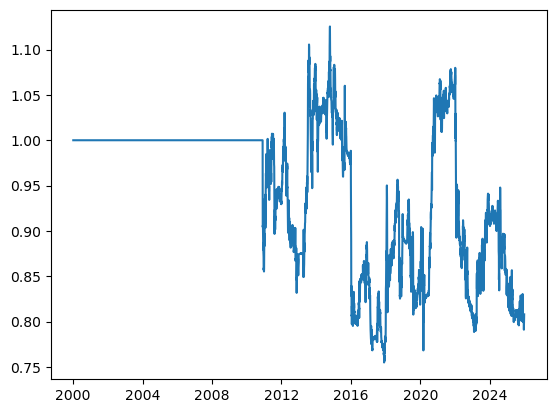

In [51]:
plt.plot(wealth)
plt.show()


=== Strategy vs Market comparison (aligned sample) ===
                         ann_return   ann_vol    sharpe    max_dd  nobs  \
name                                                                      
MonthlyExec               -0.008193  0.096885 -0.084565 -0.329332  6533   
DailyExec(Fri+TW avoid)   -0.013917  0.096930 -0.143574 -0.389846  6533   
SPY                        0.080872  0.193994  0.416881 -0.551894  6533   

                         alpha_ann      beta  t(alpha_d)  
name                                                      
MonthlyExec              -0.006192  0.027720   -0.302278  
DailyExec(Fri+TW avoid)  -0.011967  0.027646   -0.583254  
SPY                            NaN       NaN         NaN  


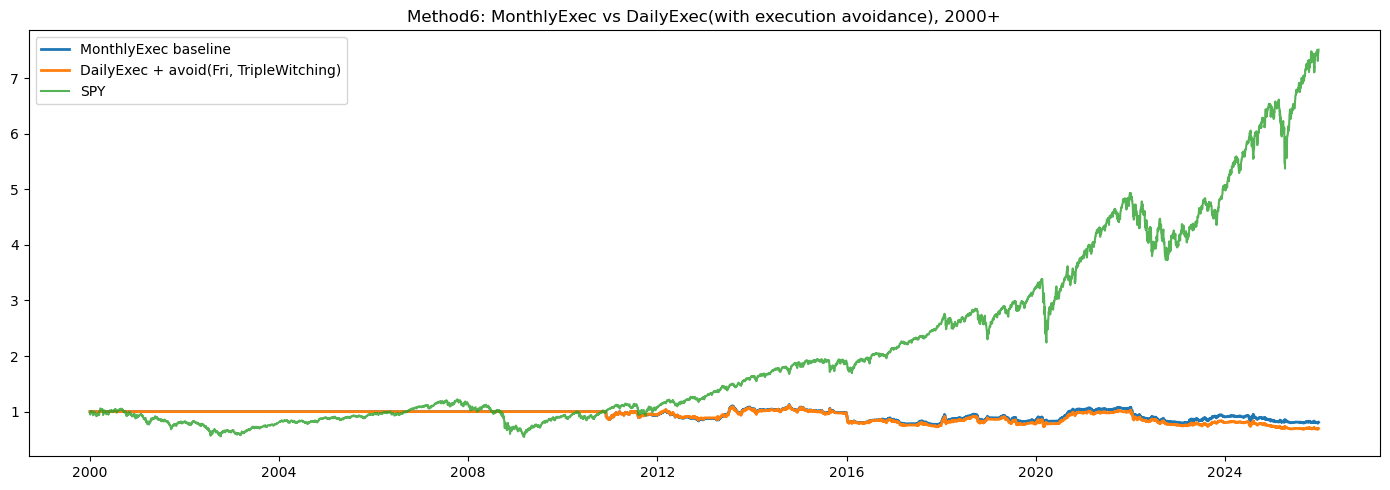

In [52]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt


# ============================================================
# 0) Month type (N/R/3) – same as your definition
# ============================================================

def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ============================================================
# 1) Load SPY daily (robust)
# ============================================================

def load_spy_daily(start="2000-01-01", end=None) -> pd.DataFrame:
    data = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)
    if data is None or len(data) == 0:
        raise ValueError("yfinance returned empty data (SPY). Retry or adjust date range.")

    if isinstance(data.columns, pd.MultiIndex):
        if ("Close", "SPY") in data.columns:
            px = data[("Close", "SPY")]
        else:
            close_cols = [c for c in data.columns if c[0] == "Close"]
            if len(close_cols) == 0:
                raise ValueError(f"Close column not found. columns={data.columns}")
            px = data[close_cols[0]]
    else:
        if "Close" not in data.columns:
            raise ValueError(f"Close column not found. columns={data.columns}")
        px = data["Close"]

    if isinstance(px, pd.DataFrame):
        if px.shape[1] != 1:
            raise ValueError(f"Unexpected Close DataFrame shape: {px.shape}")
        px = px.iloc[:, 0]

    px = px.dropna().rename("px")
    df = px.to_frame()
    df["ret_total"] = df["px"].pct_change()
    df = df.dropna()

    # For now rf=0 (you can plug in T-bill daily if you want)
    df["rf"] = 0.0
    df["mkt_excess"] = df["ret_total"] - df["rf"]
    return df


# ============================================================
# 2) Daily -> monthly total return (compound)
# ============================================================

def daily_to_monthly_total(daily_total_ret: pd.Series) -> pd.Series:
    daily_total_ret = daily_total_ret.dropna().astype(float)
    monthly_total = (1.0 + daily_total_ret).resample("M").prod() - 1.0
    return monthly_total.dropna()


# ============================================================
# 3) Method6 core (monthly): S_t, x_t, beta_t, w_raw_t
# ============================================================

def compute_S_and_x_for_method6(mkt_total: pd.Series):
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")
    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


def build_method6_raw_weights(mkt_total: pd.Series, min_obs=120):
    idx = mkt_total.index
    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj = mkt_total - mkt_mean
    beta = pd.Series(index=idx, dtype=float)

    for t in idx:
        mask = (idx <= t) & x.notna() & y_adj.notna()
        n = int(mask.sum())
        if n < min_obs:
            beta[t] = np.nan
            continue
        xi = x[mask].values
        yi = y_adj[mask].values
        denom = float((xi**2).sum())
        beta[t] = float((xi * yi).sum() / denom) if denom > 0 else np.nan

    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = float(beta[t] * x[t])

    return x, beta, w_raw, month_type


# ============================================================
# 4) Calendar helpers for execution rules
#    - Friday avoid
#    - Triple witching avoid (3rd Friday in Mar/Jun/Sep/Dec)
# ============================================================

def third_friday_dates(trading_index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    start = trading_index.min().to_period("M").start_time
    end = trading_index.max().to_period("M").end_time
    cal = pd.date_range(start=start, end=end, freq="WOM-3FRI")

    snapped = []
    for d in cal:
        dd = d
        while dd not in trading_index:
            dd = dd - pd.Timedelta(days=1)
            if dd < trading_index.min():
                break
        if dd in trading_index:
            snapped.append(dd)
    return pd.DatetimeIndex(sorted(set(snapped)))


def build_triple_witching_mask(daily_index: pd.DatetimeIndex) -> pd.Series:
    tf = third_friday_dates(daily_index)
    is_third_friday = pd.Series(daily_index.isin(tf), index=daily_index)
    is_q_end_month = pd.Series(daily_index.month.isin([3, 6, 9, 12]), index=daily_index)
    is_tw = (is_third_friday & is_q_end_month)
    return is_tw.rename("is_triple_witching")


def build_friday_mask(daily_index: pd.DatetimeIndex) -> pd.Series:
    return pd.Series(daily_index.dayofweek == 4, index=daily_index).rename("is_friday")


# ============================================================
# 5) Monthly execution baseline (month-end weight -> next month)
#    - Apply monthly weight (decided at month t) to month t+1 daily returns
#    - Optionally monthly vol targeting with rolling window on monthly returns
# ============================================================

def map_monthly_weight_to_daily_next_month(w_monthly: pd.Series, daily_index: pd.DatetimeIndex) -> pd.Series:
    """
    Use w(t_month_end) for the next month's daily trading days.
    Implementation: shift(1) on monthly series then forward-fill on daily.
    """
    w_m = w_monthly.sort_index().astype(float)
    w_m_shift = w_m.shift(1)  # pre-month-end -> next month usage
    w_d = w_m_shift.resample("D").ffill().reindex(daily_index).ffill().fillna(0.0)
    return w_d.rename("w_raw_daily")


def rolling_scale_from_returns(r: pd.Series,
                               target_vol_ann: float = 0.10,
                               window: int = 63,
                               periods_per_year: int = 252,
                               min_obs: int = 20) -> pd.Series:
    """
    Rolling annualized volatility scaling (shift(1) for no-leak).
    """
    r = r.astype(float)
    vol_ann = r.rolling(window, min_periods=min_obs).std(ddof=1) * np.sqrt(periods_per_year)
    scale = (target_vol_ann / vol_ann).replace([np.inf, -np.inf], np.nan)
    scale = scale.shift(1).fillna(1.0)
    return scale.rename("scale")


# ============================================================
# 6) Daily execution with "do-not-rebalance" filters
#    Key idea:
#      - There's a desired weight w_desired(t) each day (from monthly signal mapping)
#      - Actual weight w_actual(t) updates to w_desired(t) ONLY if rebalance is allowed
#      - Otherwise w_actual(t) = w_actual(t-1)
# ============================================================

def apply_rebalance_filters_to_daily_weights(
    w_desired: pd.Series,
    forbid_rebalance_mask: pd.Series,
) -> pd.Series:
    """
    forbid_rebalance_mask[t]=True means: do NOT update weight at day t (keep yesterday's weight).
    This is a pure execution rule; signal is unchanged.
    """
    w_desired = w_desired.copy().astype(float)
    mask = forbid_rebalance_mask.reindex(w_desired.index).fillna(False).astype(bool)

    w_actual = pd.Series(index=w_desired.index, dtype=float)
    prev = 0.0
    for t in w_desired.index:
        if mask.loc[t]:
            w_actual.loc[t] = prev
        else:
            val = float(w_desired.loc[t])
            w_actual.loc[t] = val
            prev = val
    return w_actual.rename("w_actual")


# ============================================================
# 7) Build & compare:
#    (A) monthly-exec baseline
#    (B) daily-exec with filters (Fri + TripleWitching)
# ============================================================

def build_method6_monthly_and_daily_paths(
    start="2000-01-01",
    end=None,
    min_obs_monthly_beta: int = 120,
    target_vol_ann: float = 0.10,
    vol_window_days: int = 63,
    max_leverage: float = 3.0,
):
    # --- Daily market data ---
    daily = load_spy_daily(start=start, end=end)
    idx_d = daily.index

    # --- Monthly signal construction (Method6) ---
    mkt_total_m = daily_to_monthly_total(daily["ret_total"])
    x_m, beta_m, w_raw_m, month_type_m = build_method6_raw_weights(mkt_total=mkt_total_m, min_obs=min_obs_monthly_beta)

    monthly = pd.DataFrame({
        "mkt_total": mkt_total_m,
        "x": x_m,
        "beta": beta_m,
        "w_raw": w_raw_m,
        "month_type": month_type_m,
    }).dropna(subset=["mkt_total"]).sort_index()

    # --- Map monthly raw weights to daily desired weights (next-month application) ---
    w_desired_raw_d = map_monthly_weight_to_daily_next_month(monthly["w_raw"], idx_d)
    w_desired_raw_d = w_desired_raw_d.clip(-max_leverage, max_leverage)

    # ------------------------------------------------------------
    # (A) Baseline daily path from monthly exec (no filters)
    #     - raw -> rolling vol target -> scaled weights
    # ------------------------------------------------------------
    strat_excess_raw_A = w_desired_raw_d * daily["mkt_excess"]
    scale_A = rolling_scale_from_returns(strat_excess_raw_A,
                                         target_vol_ann=target_vol_ann,
                                         window=vol_window_days,
                                         periods_per_year=252,
                                         min_obs=max(20, vol_window_days // 3))
    w_scaled_A = (w_desired_raw_d * scale_A).clip(-max_leverage, max_leverage)
    strat_excess_A = w_scaled_A * daily["mkt_excess"]

    out_A = daily.copy()
    out_A["w_raw_desired"] = w_desired_raw_d
    out_A["scale"] = scale_A
    out_A["w_scaled"] = w_scaled_A
    out_A["strat_excess_d"] = strat_excess_A

    # ------------------------------------------------------------
    # (B) Daily execution with filters:
    #     forbid rebalance on Friday OR triple witching day
    #     - Here "rebalance" means updating raw desired weight.
    #       scale is computed on realized returns as usual (shifted).
    # ------------------------------------------------------------
    is_friday = build_friday_mask(idx_d)
    is_tw = build_triple_witching_mask(idx_d)
    forbid = (is_friday | is_tw).rename("forbid_rebalance")

    w_actual_raw_B = apply_rebalance_filters_to_daily_weights(
        w_desired=w_desired_raw_d,
        forbid_rebalance_mask=forbid
    ).clip(-max_leverage, max_leverage)

    strat_excess_raw_B = w_actual_raw_B * daily["mkt_excess"]
    scale_B = rolling_scale_from_returns(strat_excess_raw_B,
                                         target_vol_ann=target_vol_ann,
                                         window=vol_window_days,
                                         periods_per_year=252,
                                         min_obs=max(20, vol_window_days // 3))
    w_scaled_B = (w_actual_raw_B * scale_B).clip(-max_leverage, max_leverage)
    strat_excess_B = w_scaled_B * daily["mkt_excess"]

    out_B = daily.copy()
    out_B["w_raw_desired"] = w_desired_raw_d
    out_B["forbid_rebalance"] = forbid
    out_B["w_raw_actual"] = w_actual_raw_B
    out_B["scale"] = scale_B
    out_B["w_scaled"] = w_scaled_B
    out_B["strat_excess_d"] = strat_excess_B
    out_B["is_friday"] = is_friday
    out_B["is_triple_witching"] = is_tw

    return monthly, out_A, out_B


# ============================================================
# 8) Performance summary + plotting
# ============================================================

def max_drawdown(r: pd.Series) -> float:
    wealth = (1.0 + r.fillna(0.0)).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return float(dd.min())

def annualized_stats(r: pd.Series, periods_per_year=252):
    r = pd.to_numeric(r, errors="coerce").astype(float).dropna()
    ann_ret = (1.0 + r).prod() ** (periods_per_year / len(r)) - 1.0
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    mdd = max_drawdown(r)
    return ann_ret, ann_vol, sharpe, mdd, int(len(r))

def capm_alpha_beta_hac(r_port: pd.Series, r_mkt: pd.Series, hac_lags=5):
    df = pd.DataFrame({"rp": r_port, "rm": r_mkt}).dropna()
    y = df["rp"].astype(float)
    X = sm.add_constant(df["rm"].astype(float))
    m = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    alpha_d = float(m.params["const"])
    beta = float(m.params["rm"])
    t_alpha = float(m.tvalues["const"])
    return alpha_d, beta, t_alpha

def build_comparison_table(out_A: pd.DataFrame, out_B: pd.DataFrame, name_A="MonthlyExec", name_B="DailyExec(Fri+TW avoid)"):
    # align common index
    idx = out_A.index.intersection(out_B.index)
    A = out_A.loc[idx].copy()
    B = out_B.loc[idx].copy()

    mkt = A["mkt_excess"].astype(float)  # same series

    rows = []
    for name, r in [(name_A, A["strat_excess_d"]), (name_B, B["strat_excess_d"]), ("SPY", mkt)]:
        ann_ret, ann_vol, sharpe, mdd, n = annualized_stats(r)
        rows.append({"name": name, "ann_return": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": mdd, "nobs": n})

    tbl = pd.DataFrame(rows).set_index("name")

    # CAPM alpha/beta for each strategy vs SPY
    for nm, r in [(name_A, A["strat_excess_d"]), (name_B, B["strat_excess_d"])]:
        alpha_d, beta, t_alpha = capm_alpha_beta_hac(r, mkt, hac_lags=5)
        tbl.loc[nm, "alpha_ann"] = alpha_d * 252
        tbl.loc[nm, "beta"] = beta
        tbl.loc[nm, "t(alpha_d)"] = t_alpha

    return tbl

def plot_paths(out_A: pd.DataFrame, out_B: pd.DataFrame, title="Cumulative wealth (excess)"):
    idx = out_A.index.intersection(out_B.index)
    A = out_A.loc[idx, "strat_excess_d"].fillna(0.0)
    B = out_B.loc[idx, "strat_excess_d"].fillna(0.0)
    M = out_A.loc[idx, "mkt_excess"].fillna(0.0)

    wa = (1.0 + A).cumprod()
    wb = (1.0 + B).cumprod()
    wm = (1.0 + M).cumprod()

    plt.figure(figsize=(14, 5))
    plt.plot(wa, label="MonthlyExec baseline", linewidth=2)
    plt.plot(wb, label="DailyExec + avoid(Fri, TripleWitching)", linewidth=2)
    plt.plot(wm, label="SPY", linewidth=1.5, alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 9) Run (2000+)
# ============================================================

if __name__ == "__main__":
    monthly, out_A, out_B = build_method6_monthly_and_daily_paths(
        start="2000-01-01",
        end=None,
        min_obs_monthly_beta=120,
        target_vol_ann=0.10,
        vol_window_days=63,
        max_leverage=3.0,
    )

    # comparison
    tbl = build_comparison_table(out_A, out_B)
    print("\n=== Strategy vs Market comparison (aligned sample) ===")
    print(tbl)

    # plot paths
    plot_paths(out_A, out_B, title="Method6: MonthlyExec vs DailyExec(with execution avoidance), 2000+")



=== Comparison table (monthly frequency, aligned) ===
                                   ann_return  ann_vol  sharpe  nobs_months
name                                                                       
Monthly baseline (FF)                     NaN      NaN     NaN            0
Daily exec avoid(Fri,TW)->monthly         NaN      NaN     NaN            0
Market                                    NaN      NaN     NaN            0


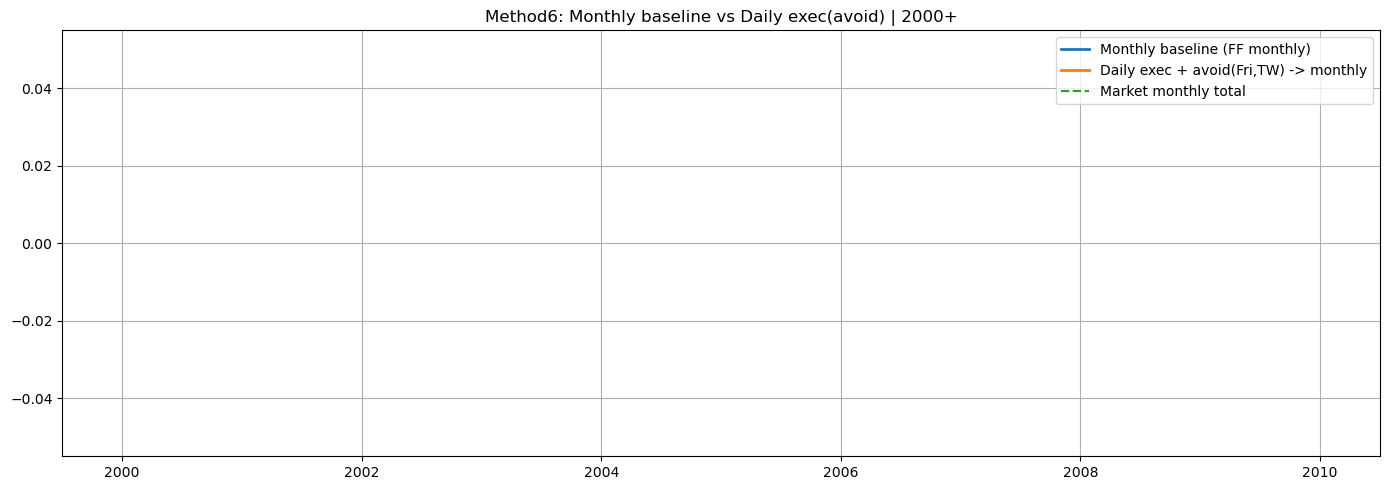


[Scales]
Monthly baseline scale k = 349.596721  (target_vol_monthly=0.05)
Daily exec scale k       = 177.272444  (target_vol_ann_daily=0.1)


In [53]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf


# ============================================================
# 0) Ken French (monthly) 読み込み（あなたのコード）
# ============================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf']         = ff['RF'] / 100.0
    return ff[['mkt_excess', 'rf']].dropna()


# ============================================================
# 1) month_type（あなたの定義）
# ============================================================

def classify_month_type(index: pd.DatetimeIndex) -> pd.Series:
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ============================================================
# 2) Method6: S_t, x_t（あなたの定義）
# ============================================================

def compute_S_and_x_for_method6(mkt_total: pd.Series):
    idx = mkt_total.index
    month_type = classify_month_type(idx)
    is_newsy = (month_type == "N")
    news_series = mkt_total[is_newsy]

    S = pd.Series(index=idx, dtype=float)
    for t in idx:
        past = news_series[news_series.index <= t]
        if len(past) >= 4:
            S[t] = past.iloc[-4:].sum()
        else:
            S[t] = np.nan

    x = pd.Series(index=idx, dtype=float)
    S_hist = []
    for i in range(1, len(idx)):
        prev_date = idx[i-1]
        curr_date = idx[i]

        s_prev = S.loc[prev_date]
        if np.isnan(s_prev):
            x[curr_date] = np.nan
            continue

        S_hist.append(s_prev)
        s_bar = float(np.mean(S_hist))

        sign = -1.0 if is_newsy[curr_date] else 1.0
        x[curr_date] = sign * (s_prev - s_bar)

    return S, x, month_type


# ============================================================
# 3) Method6: β推定（rolling版：あなたのベースライン）
# ============================================================

def build_method6_raw_weights_rolling(
    ff: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 120,
):
    mkt_excess = ff["mkt_excess"].copy()
    rf         = ff["rf"].copy()
    mkt_total  = mkt_excess + rf
    idx        = mkt_total.index

    S, x, month_type = compute_S_and_x_for_method6(mkt_total)

    mkt_mean = mkt_total.expanding().mean().shift(1)
    y_adj    = mkt_total - mkt_mean

    beta = pd.Series(index=idx, dtype=float)
    lookback_months = lookback_years * 12

    for i, t in enumerate(idx):
        start_i = max(0, i - lookback_months + 1)
        win_idx = idx[start_i:(i + 1)]

        x_win = x.loc[win_idx]
        y_win = y_adj.loc[win_idx]
        mask  = x_win.notna() & y_win.notna()
        n     = int(mask.sum())

        if n < min_obs:
            beta[t] = np.nan
            continue

        xi = x_win[mask].values
        yi = y_win[mask].values
        denom = float((xi ** 2).sum())
        beta[t] = float((xi * yi).sum() / denom) if denom > 0 else np.nan

    w_raw = pd.Series(index=idx, dtype=float)
    for t in idx:
        if np.isnan(beta[t]) or np.isnan(x[t]):
            w_raw[t] = 0.0
        else:
            w_raw[t] = float(beta[t] * x[t])

    return x, beta, w_raw


# ============================================================
# 4) vol-target（ベースラインと同じ：全期間で1回スケール）
# ============================================================

def vol_target_from_weights_monthly_once(
    mkt_excess: pd.Series,
    rf: pd.Series,
    w_raw: pd.Series,
    target_vol: float = 0.05,
) -> pd.DataFrame:
    data = pd.concat(
        [mkt_excess.rename("mkt_excess"),
         rf.rename("rf"),
         w_raw.rename("w_raw")],
        axis=1
    ).dropna(subset=["mkt_excess", "rf"])

    strat_excess_raw = data["w_raw"] * data["mkt_excess"]

    realized_vol = strat_excess_raw.std(ddof=1)
    if realized_vol is None or realized_vol == 0 or np.isnan(realized_vol):
        scale = 1.0
    else:
        scale = target_vol / realized_vol

    w_scaled     = data["w_raw"] * scale
    strat_excess = strat_excess_raw * scale
    strat_total  = data["rf"] + strat_excess

    out = pd.DataFrame({
        "mkt_excess": data["mkt_excess"],
        "rf": data["rf"],
        "w_raw": data["w_raw"],
        "w_scaled": w_scaled,
        "strat_excess_raw": strat_excess_raw,
        "strat_excess": strat_excess,
        "strat_total": strat_total,
    })
    out.attrs["scale"] = float(scale)
    out.attrs["target_vol"] = float(target_vol)
    return out


# ============================================================
# 5) 日次SPY取得（分配金調整込み）
# ============================================================

def load_spy_daily(start="2000-01-01", end=None) -> pd.DataFrame:
    data = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)
    if data is None or len(data) == 0:
        raise ValueError("yfinance returned empty data (SPY).")

    if isinstance(data.columns, pd.MultiIndex):
        if ("Close", "SPY") in data.columns:
            px = data[("Close", "SPY")]
        else:
            close_cols = [c for c in data.columns if c[0] == "Close"]
            if len(close_cols) == 0:
                raise ValueError(f"Close column not found. columns={data.columns}")
            px = data[close_cols[0]]
    else:
        px = data["Close"]

    if isinstance(px, pd.DataFrame):
        px = px.iloc[:, 0]

    px = px.dropna().rename("px")
    df = px.to_frame()
    df["ret_total"] = df["px"].pct_change()
    df = df.dropna()

    # ここは簡便に rf=0 とする（rfを入れたい場合は後述）
    df["rf_d"] = 0.0
    df["mkt_excess_d"] = df["ret_total"] - df["rf_d"]
    return df


def daily_to_monthly_total(daily_total_ret: pd.Series) -> pd.Series:
    daily_total_ret = daily_total_ret.dropna().astype(float)
    monthly_total = (1.0 + daily_total_ret).resample("M").prod() - 1.0
    return monthly_total.dropna()


# ============================================================
# 6) 月次wを日次に（前月末確定→当月に適用）
# ============================================================

def map_monthly_weight_to_daily_next_month(w_monthly: pd.Series, daily_index: pd.DatetimeIndex) -> pd.Series:
    w_m = w_monthly.sort_index().astype(float)
    w_m_shift = w_m.shift(1)  # 前月末で確定したものを当月に使う
    w_d = w_m_shift.resample("D").ffill().reindex(daily_index).ffill().fillna(0.0)
    return w_d.rename("w_raw_desired")


# ============================================================
# 7) 執行回避ルール：金曜/トリプルウィッチング日はリバランスしない
# ============================================================

def third_friday_dates(trading_index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    start = trading_index.min().to_period("M").start_time
    end = trading_index.max().to_period("M").end_time
    cal = pd.date_range(start=start, end=end, freq="WOM-3FRI")

    snapped = []
    for d in cal:
        dd = d
        while dd not in trading_index:
            dd = dd - pd.Timedelta(days=1)
            if dd < trading_index.min():
                break
        if dd in trading_index:
            snapped.append(dd)
    return pd.DatetimeIndex(sorted(set(snapped)))


def build_triple_witching_mask(daily_index: pd.DatetimeIndex) -> pd.Series:
    tf = third_friday_dates(daily_index)
    is_third_friday = pd.Series(daily_index.isin(tf), index=daily_index)
    is_q_end_month = pd.Series(daily_index.month.isin([3, 6, 9, 12]), index=daily_index)
    return (is_third_friday & is_q_end_month).rename("is_triple_witching")


def build_friday_mask(daily_index: pd.DatetimeIndex) -> pd.Series:
    return pd.Series(daily_index.dayofweek == 4, index=daily_index).rename("is_friday")


def apply_rebalance_filters_to_daily_weights(
    w_desired: pd.Series,
    forbid_rebalance_mask: pd.Series,
) -> pd.Series:
    w_desired = w_desired.astype(float)
    mask = forbid_rebalance_mask.reindex(w_desired.index).fillna(False).astype(bool)

    w_actual = pd.Series(index=w_desired.index, dtype=float)
    prev = 0.0
    for t in w_desired.index:
        if mask.loc[t]:
            w_actual.loc[t] = prev
        else:
            val = float(w_desired.loc[t])
            w_actual.loc[t] = val
            prev = val
    return w_actual.rename("w_raw_actual")


# ============================================================
# 8) 日次執行のvol-target：ベースラインと合わせて「全期間1回スケール」
# ============================================================

def vol_target_daily_once(
    mkt_excess_d: pd.Series,
    rf_d: pd.Series,
    w_raw_d: pd.Series,
    target_vol_ann: float = 0.10,
):
    """
    日次 raw 戦略超過 r_raw = w_raw_d * mkt_excess_d の年率ボラで 1回スケール。
    scale = target_vol_ann / (std(r_raw)*sqrt(252))
    """
    df = pd.concat([mkt_excess_d.rename("mkt_excess_d"),
                    rf_d.rename("rf_d"),
                    w_raw_d.rename("w_raw_d")], axis=1).dropna()

    r_raw = df["w_raw_d"] * df["mkt_excess_d"]
    vol_ann = r_raw.std(ddof=1) * math.sqrt(252)
    if vol_ann is None or vol_ann == 0 or np.isnan(vol_ann):
        scale = 1.0
    else:
        scale = float(target_vol_ann / vol_ann)

    w_scaled = df["w_raw_d"] * scale
    r_excess = r_raw * scale
    r_total = df["rf_d"] + r_excess

    out = pd.DataFrame({
        "mkt_excess_d": df["mkt_excess_d"],
        "rf_d": df["rf_d"],
        "w_raw_d": df["w_raw_d"],
        "w_scaled_d": w_scaled,
        "strat_excess_raw_d": r_raw,
        "strat_excess_d": r_excess,
        "strat_total_d": r_total,
    })
    out.attrs["scale"] = scale
    out.attrs["target_vol_ann"] = float(target_vol_ann)
    return out


def daily_total_to_monthly_total(daily_total_ret: pd.Series) -> pd.Series:
    """
    日次トータルリターン -> 月次トータルリターンへ（複利）
    """
    return (1.0 + daily_total_ret.dropna().astype(float)).resample("M").prod() - 1.0


# ============================================================
# 9) 比較用：統計/プロット
# ============================================================

def annualized_stats_monthly(r_m: pd.Series):
    r_m = r_m.dropna().astype(float)
    mu_m = r_m.mean()
    sd_m = r_m.std(ddof=1)
    mu_a = mu_m * 12
    sd_a = sd_m * math.sqrt(12)
    sharpe = mu_a / sd_a if sd_a > 0 else np.nan
    return mu_a, sd_a, sharpe

def compare_table_monthly(rA: pd.Series, rB: pd.Series, rM: pd.Series, nameA="Monthly baseline", nameB="Daily exec (avoid)"):
    idx = rA.dropna().index.intersection(rB.dropna().index).intersection(rM.dropna().index)
    A = rA.loc[idx]
    B = rB.loc[idx]
    M = rM.loc[idx]

    rows = []
    for nm, rr in [(nameA, A), (nameB, B), ("Market", M)]:
        mu_a, sd_a, sh = annualized_stats_monthly(rr)
        rows.append({"name": nm, "ann_return": mu_a, "ann_vol": sd_a, "sharpe": sh, "nobs_months": int(len(rr))})
    return pd.DataFrame(rows).set_index("name"), idx

def plot_wealth_monthly(rA: pd.Series, rB: pd.Series, rM: pd.Series, idx, title="Monthly wealth comparison"):
    A = rA.loc[idx].fillna(0.0)
    B = rB.loc[idx].fillna(0.0)
    M = rM.loc[idx].fillna(0.0)

    wA = (1.0 + A).cumprod()
    wB = (1.0 + B).cumprod()
    wM = (1.0 + M).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(wA, label="Monthly baseline (FF monthly)", linewidth=2)
    plt.plot(wB, label="Daily exec + avoid(Fri,TW) -> monthly", linewidth=2)
    plt.plot(wM, label="Market monthly total", linestyle="--", linewidth=1.6)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# 10) メイン：2000年以降で比較
# ============================================================

def run_comparison_2000_plus(
    ff_csv_path="F-F_Research_Data_Factors.csv",
    start="2000-01-01",
    end=None,
    lookback_years=20,
    min_obs=120,
    target_vol_monthly=0.05,   # 月次ベースラインのtarget vol
    target_vol_ann_daily=0.10, # 日次執行の年率target vol（目安：月次0.05≒年率~0.173だがここは運用意図で調整）
    max_leverage=3.0,
):
    # ---------- Monthly baseline (Ken French monthly) ----------
    ff = load_ff_monthly_from_ken_french(ff_csv_path)
    ff = ff.loc[pd.Timestamp(start):] if start is not None else ff

    x_m6, beta_m6, w_m6 = build_method6_raw_weights_rolling(ff, lookback_years=lookback_years, min_obs=min_obs)
    strat_m6 = vol_target_from_weights_monthly_once(
        ff["mkt_excess"], ff["rf"], w_m6, target_vol=target_vol_monthly
    )
    # baseline monthly total return
    rA = strat_m6["strat_total"].rename("r_monthly_baseline")

    # market monthly total (FF)
    rM = (ff["mkt_excess"] + ff["rf"]).reindex(rA.index).rename("r_mkt_monthly")

    # ---------- Daily exec (SPY daily) ----------
    daily = load_spy_daily(start=start, end=end)
    idx_d = daily.index

    # Method6 signal is monthly; build monthly total from daily
    mkt_total_m_from_daily = daily_to_monthly_total(daily["ret_total"])

    # x,beta,w using the same rolling method on this monthly series
    # ここでは rf=0 なので mkt_total = monthly_total でOK（厳密に揃えるなら月次rfを入れる）
    # ただし month_type/N/R の定義は暦月なので整合します
    x_d_m, beta_d_m, w_d_m = build_method6_raw_weights_rolling(
        pd.DataFrame({"mkt_excess": mkt_total_m_from_daily, "rf": 0.0}, index=mkt_total_m_from_daily.index),
        lookback_years=lookback_years,
        min_obs=min_obs
    )

    # desired daily raw weights (use previous month-end weight for current month)
    w_desired_raw_d = map_monthly_weight_to_daily_next_month(w_d_m, idx_d).clip(-max_leverage, max_leverage)

    # execution avoidance masks
    is_friday = build_friday_mask(idx_d)
    is_tw = build_triple_witching_mask(idx_d)
    forbid = (is_friday | is_tw).rename("forbid_rebalance")

    w_actual_raw_d = apply_rebalance_filters_to_daily_weights(w_desired_raw_d, forbid).clip(-max_leverage, max_leverage)

    # daily vol-target once (to mimic your baseline style)
    daily_strat = vol_target_daily_once(
        mkt_excess_d=daily["mkt_excess_d"],
        rf_d=daily["rf_d"],
        w_raw_d=w_actual_raw_d,
        target_vol_ann=target_vol_ann_daily
    )

    # daily total -> monthly total
    rB = daily_total_to_monthly_total(daily_strat["strat_total_d"]).rename("r_monthly_from_daily_exec")

    # align on common monthly index (2000+)
    rA = rA.loc[pd.Timestamp(start):]
    rB = rB.loc[pd.Timestamp(start):]
    rM2 = rM.copy()

    tbl, idx = compare_table_monthly(rA, rB, rM2, nameA="Monthly baseline (FF)", nameB="Daily exec avoid(Fri,TW)->monthly")
    print("\n=== Comparison table (monthly frequency, aligned) ===")
    print(tbl)

    plot_wealth_monthly(rA, rB, rM2, idx, title="Method6: Monthly baseline vs Daily exec(avoid) | 2000+")

    # 追加：スケール係数の表示（両者）
    print("\n[Scales]")
    print(f"Monthly baseline scale k = {strat_m6.attrs['scale']:.6f}  (target_vol_monthly={target_vol_monthly})")
    print(f"Daily exec scale k       = {daily_strat.attrs['scale']:.6f}  (target_vol_ann_daily={target_vol_ann_daily})")

    return {
        "ff": ff,
        "monthly_baseline": strat_m6,
        "daily_exec": daily_strat,
        "rA_monthly": rA,
        "rB_monthly": rB,
        "rM_monthly": rM2,
        "table": tbl,
        "common_index": idx,
        "forbid_mask_daily": forbid,
        "w_raw_desired_daily": w_desired_raw_d,
        "w_raw_actual_daily": w_actual_raw_d,
    }


if __name__ == "__main__":
    out = run_comparison_2000_plus(
        ff_csv_path="F-F_Research_Data_Factors.csv",
        start="2000-01-01",
        end=None,
        lookback_years=20,
        min_obs=120,
        target_vol_monthly=0.05,
        target_vol_ann_daily=0.10,
        max_leverage=3.0,
    )



--- BASIC CHECKS ---
ff: DF shape=(310, 2), idx=[2000-01-01 00:00:00 .. 2025-10-01 00:00:00], dtypes=[dtype('float64'), dtype('float64')]...
monthly_baseline(strat_m6): DF shape=(310, 7), idx=[2000-01-01 00:00:00 .. 2025-10-01 00:00:00], dtypes=[dtype('float64'), dtype('float64'), dtype('float64')]...
daily_exec(daily_strat): DF shape=(6533, 7), idx=[2000-01-04 00:00:00 .. 2025-12-23 00:00:00], dtypes=[dtype('float64'), dtype('float64'), dtype('float64')]...

--- MONTHLY SERIES CHECKS ---
rA_monthly: SER len=310, nonna=310, idx=[2000-01-01 00:00:00 .. 2025-10-01 00:00:00], dtype=float64
rB_monthly: SER len=312, nonna=312, idx=[2000-01-31 00:00:00 .. 2025-12-31 00:00:00], dtype=float64
rM_monthly: SER len=310, nonna=310, idx=[2000-01-01 00:00:00 .. 2025-10-01 00:00:00], dtype=float64

Index types:
rA idx type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
rB idx type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
rM idx type: <class 'pandas.core.indexes.datetimes.Dateti

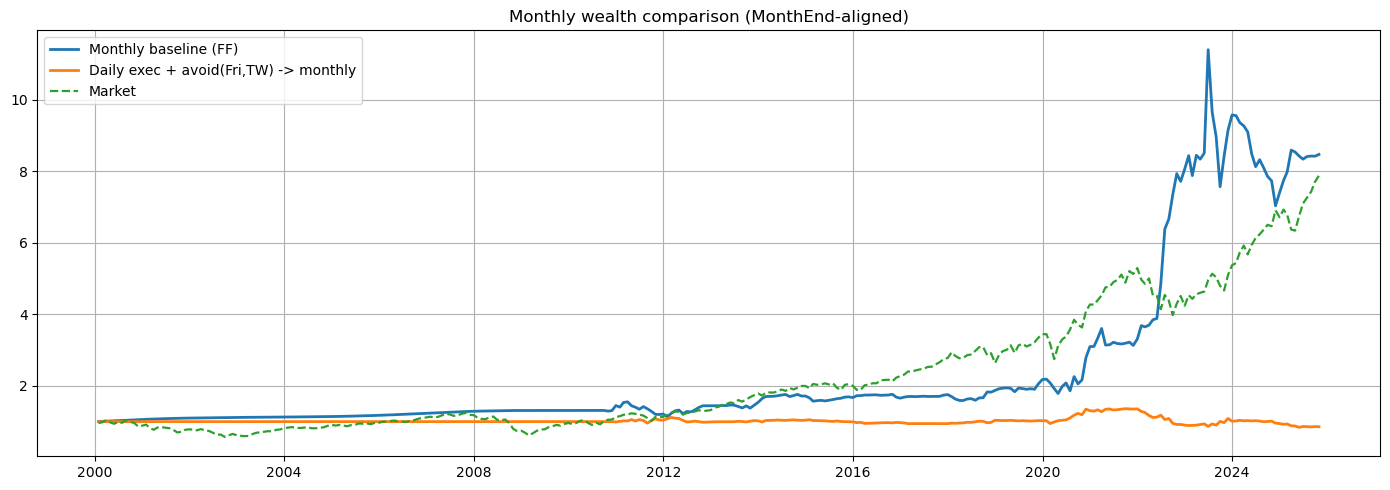

In [54]:
def debug_and_compare(out):
    ff = out["ff"]
    strat_m6 = out["monthly_baseline"]
    daily_strat = out["daily_exec"]
    rA = out["rA_monthly"]
    rB = out["rB_monthly"]
    rM = out["rM_monthly"]

    def info(name, s):
        if s is None:
            print(f"{name}: None")
            return
        if isinstance(s, pd.DataFrame):
            idx = s.index
            print(f"{name}: DF shape={s.shape}, idx=[{idx.min()} .. {idx.max()}], dtypes={list(s.dtypes)[:3]}...")
        else:
            idx = s.index
            print(f"{name}: SER len={len(s)}, nonna={int(s.notna().sum())}, idx=[{idx.min()} .. {idx.max()}], dtype={s.dtype}")

    print("\n--- BASIC CHECKS ---")
    info("ff", ff)
    info("monthly_baseline(strat_m6)", strat_m6)
    info("daily_exec(daily_strat)", daily_strat)

    print("\n--- MONTHLY SERIES CHECKS ---")
    info("rA_monthly", rA)
    info("rB_monthly", rB)
    info("rM_monthly", rM)

    # show head/tail of indices (helps when index types mismatch)
    print("\nIndex types:")
    print("rA idx type:", type(rA.index))
    print("rB idx type:", type(rB.index))
    print("rM idx type:", type(rM.index))

    # attempt robust alignment by converting to month-end timestamps
    def to_month_end_index(s):
        s2 = s.copy()
        # ensure Timestamp index
        s2.index = pd.to_datetime(s2.index)
        # normalize to month-end
        s2.index = s2.index.to_period("M").to_timestamp("M")
        s2 = s2.sort_index()
        return s2

    rA2 = to_month_end_index(rA.dropna())
    rB2 = to_month_end_index(rB.dropna())
    rM2 = to_month_end_index(rM.dropna())

    idx = rA2.index.intersection(rB2.index).intersection(rM2.index)
    print("\nAligned common months:", len(idx), " from ", (idx.min() if len(idx)>0 else None), " to ", (idx.max() if len(idx)>0 else None))

    if len(idx) == 0:
        print("\n[ERROR] common index is empty. Likely one of the series is empty after dropna.")
        print("non-na counts:", len(rA2), len(rB2), len(rM2))
        return None

    # recompute table
    def annualized_stats_monthly(r_m):
        r_m = r_m.dropna().astype(float)
        mu_m = r_m.mean()
        sd_m = r_m.std(ddof=1)
        mu_a = mu_m * 12
        sd_a = sd_m * math.sqrt(12)
        sharpe = mu_a / sd_a if sd_a > 0 else np.nan
        return mu_a, sd_a, sharpe

    rows = []
    for nm, rr in [("Monthly baseline (FF)", rA2.loc[idx]),
                   ("Daily exec avoid(Fri,TW)->monthly", rB2.loc[idx]),
                   ("Market", rM2.loc[idx])]:
        mu_a, sd_a, sh = annualized_stats_monthly(rr)
        rows.append({"name": nm, "ann_return": mu_a, "ann_vol": sd_a, "sharpe": sh, "nobs_months": int(len(rr))})
    tbl = pd.DataFrame(rows).set_index("name")

    print("\n=== FIXED Comparison table (monthly aligned by MonthEnd) ===")
    print(tbl)

    # plot
    wA = (1.0 + rA2.loc[idx].fillna(0.0)).cumprod()
    wB = (1.0 + rB2.loc[idx].fillna(0.0)).cumprod()
    wM = (1.0 + rM2.loc[idx].fillna(0.0)).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(wA, label="Monthly baseline (FF)", linewidth=2)
    plt.plot(wB, label="Daily exec + avoid(Fri,TW) -> monthly", linewidth=2)
    plt.plot(wM, label="Market", linestyle="--", linewidth=1.6)
    plt.title("Monthly wealth comparison (MonthEnd-aligned)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tbl, idx

# 使い方（直前の out を渡す）
res = debug_and_compare(out)
